# Book Recommender System

Author: Arpit Chaudhary, Arvind Narayanamurthy, Rituparna Jawahar

## Introduction

This project is an implementation of a recommender system that suggests books to a user based on the books that he/she liked. Matrix factorization based model is used to predict user ratings of all the books in the database for the particular user. Based on these predicted ratings a book is recommended to the user that we predict he would rate the highest.

## Use Cases

1. Libraries have thousands of books. Users are aware of a very small subset of all the available books. A recommender system used in the context of a library will expose readers to a wider array of books by recommending a new book based on the books they have liked in the past.

2. A recommender system can be can be used in any context, from movies to products by changing the data fed to the system. All e-commerce sites need a recommender system to stay competitive. 


## Data Source

We scraped information about top selling books on Amazon.com and associated user reviews. Information extracted from amazon.com includes:

- Book Information
    - Book Name :  Name of the book
    - ISBN.10 : Unique book identifier
    - ISBN.13 : Unique book identifier
    - Language : Language of the book
    - author : Comma seperated author names
    - image_url : URL for the book's cover image on amazon.com
    - review_url : URL for reviews of the book on amazon.com
    - url : Url of the Book on Amazon
- User Reviews
    - book_id : ISBN-10 of the book reviewed
    - rating : User rating for the book
    - user_link : User Profile link (Used as a key to identify users uniquely)
    - user_name : Name of the user
    
In total, we extracted 205,910 total reviews for 236 unique books.

### Data Collection Methodology

- We extracted the top bestselling books on amazon.com and scraped the above mentioned information about each of these books.
- With the book information extracted, we went ahead and scraped user reviews for all these books chunk by chunk.
- We merged all these chunks of user reviews into a big dataset to be used to train our recommender system.

## Scripts used for scraping

The scripts that we wrote for scraping can be found at:
https://github.com/arpitchaudhary/book_recommendation/tree/master/Scraping%20scripts

## Learning a model

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
from scipy.sparse.linalg import svds
import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

#### Setting the seed

To obtain reproducible results.

In [2]:
import random
random.seed(23456)
np.random.seed(23456)

## Read Data

In [3]:
books = pd.read_csv("book_data_v3.csv")
book_revs = pd.read_csv("reviews_v6.csv")

In [4]:
books.head()

,ISBN.10,ISBN.13,Language,author,image_url,name,review_url,url
0,1911015486,978-1911015482,english,Piggyback,https://images-na.ssl-images-amazon.com/images...,The Legend of Zelda: Breath of the Wild The Co...,https://www.amazon.com/Legend-Zelda-Complete-O...,https://www.amazon.com/Legend-Zelda-Complete-O...
1,078696619X,978-0786966196,english,Wizards RPG Team,https://images-na.ssl-images-amazon.com/images...,Dungeon Master's Screen Reincarnated,https://www.amazon.com/Dungeon-Masters-Screen-...,https://www.amazon.com/Dungeon-Masters-Screen-...
2,62433970,978-0062433978,english,Christopher Moore,https://images-na.ssl-images-amazon.com/images...,Noir: A Novel,https://www.amazon.com/Noir-Novel-Christopher-...,https://www.amazon.com/Noir-Novel-Christopher-...
3,345535529,978-0345535528,english,George R. R. Martin,https://images-na.ssl-images-amazon.com/images...,A Game of Thrones / A Clash of Kings / A Storm...,https://www.amazon.com/Thrones-Clash-Kings-Swo...,https://www.amazon.com/Thrones-Clash-Kings-Swo...
4,525622136,978-0525622130,english,Daniel José Older,https://images-na.ssl-images-amazon.com/images...,Last Shot (Star Wars): A Han and Lando Novel,https://www.amazon.com/Last-Shot-Star-Wars-Lan...,https://www.amazon.com/Last-Shot-Star-Wars-Lan...


In [5]:
book_revs.head()

,rating,user_link,user_name,book_id
0,5,/gp/profile/amzn1.account.AHVQ2I7NIIICSGLMITUH...,Laurel,316769495
1,5,/gp/profile/amzn1.account.AFLBOK7ROK6O36BXI2XX...,Thomas Truthsayer,316769495
2,4,/gp/profile/amzn1.account.AFVFVS25QJVCFIMPGL44...,Amazon Customer,316769495
3,5,/gp/profile/amzn1.account.AGECMZA77X4ECMFL4L6Z...,Starlifter,316769495
4,5,/gp/profile/amzn1.account.AE5DLBCV4FX72KSZDOFE...,Mr.Punch,316769495


## Processing Data

### Deleting Unsuable Reviews

User-user and item-item based collaborative filtering required user reviews that had an associated valid user. In some cases, reviews were left ananymously or by a deleted user account, these were not used. 

In [6]:
book_revs = book_revs.dropna(how ='any')

### Generating User IDs

The 'user_link' column could have been used as the key to uniquely identify each user but is not very human readable. We created a more readable numerical id which consist of integers that can be directly used as row numbers in our feature matrix.

In [7]:
user_links = set(book_revs['user_link'])
userId_map = dict(zip(user_links, range(len(user_links))))
book_revs['user_id'] = book_revs['user_link'].apply(lambda x: userId_map.get(x))
book_revs.head()

,rating,user_link,user_name,book_id,user_id
0,5,/gp/profile/amzn1.account.AHVQ2I7NIIICSGLMITUH...,Laurel,316769495,32236
1,5,/gp/profile/amzn1.account.AFLBOK7ROK6O36BXI2XX...,Thomas Truthsayer,316769495,130373
2,4,/gp/profile/amzn1.account.AFVFVS25QJVCFIMPGL44...,Amazon Customer,316769495,165982
3,5,/gp/profile/amzn1.account.AGECMZA77X4ECMFL4L6Z...,Starlifter,316769495,155343
4,5,/gp/profile/amzn1.account.AE5DLBCV4FX72KSZDOFE...,Mr.Punch,316769495,138278


### Exploratory Data Analysis



 #### Rating Distribution
 
The graph of the distribution of ratings shows us that most books in our dataset were highly rated. This is attributed to the fact that our dataset predominantly consists of bestselling books. The model trained on this datatset is biased towards higher ratings as most of the books are highly rated.  

Expanding our dataset to include more books (not just bestsellers) would increase the accuracy. The number of books with lower rating would level out the distribution. As a result, the bias would reduce and the model would make better recommendations.

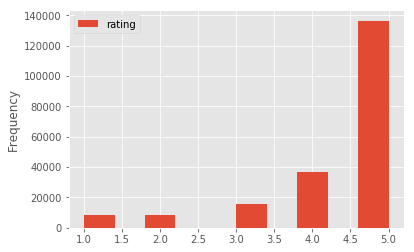

In [9]:
book_revs.plot(y='rating', kind = 'hist')

#### Unique Users and Books

In [11]:
book_ID = book_revs['book_id'].unique()
user_ID = book_revs['user_id'].unique()
print('Total unique books:', len(book_ID))
print('Total unique users: ', len(user_ID))

Total unique books: 236
Total unique users:  181240


### Creating Feature Matrices (Train, Validation and Test sets)

To be be able to feed it to matrix factorization based model, the data needs to be present in matrix format of ratings for each user per book. For our implementation, each column represents a book and each row a user. Each cell in the matrix is the rating (1-5), for the specific book by the specific user.

We are using a validation set approach and so, we need to divide the data into 3 sets:
- Train set
- Validation set (For hyper-parameter tuning)
- Test set (Testing the performance)

NOTE: To tune the hyper-parameters model is trained on the training set and error is calculated over validation set. FOr training the final model train + validation sets are used for training and test is used to calculate the error.

In [10]:
import math
def process(ratings, books, P):
    """ Given a dataframe of ratings and a random permutation, split the data into a training 
        and a testing set, in matrix form. 
        
        Args: 
            ratings (dataframe) : dataframe of ratings
            books (dataframe) : dataframe of books
            P (numpy 1D array) : random permutation vector
            
        Returns: 
            (X_tr, X_val, X_te, X_full_tr, bk_names, bk_id)  : training, validation, testing, and full_training splits of the ratings matrix (both 
                                         numpy 2D arrays), a python list of book names and book ids
                                         corresponding to the columns of the ratings matrices. 
    """
    
    bookID = ratings['book_id'].unique()
    userID = ratings['user_id'].unique()
    bks = books.set_index(['ISBN.10'])
    
    bk_names = list(bks.loc[bookID]['name'])
    bk_id = list(bks.loc[bookID].index)
    bk_dict = {mi:i for i,mi in enumerate(bookID)}
    
    X_tr = np.zeros((len(userID),len(bookID)))
    X_val = np.zeros((len(userID),len(bookID)))
    X_te = np.zeros((len(userID),len(bookID)))
    X_full_tr = np.zeros((len(userID),len(bookID)))
    
    tr_size = math.floor(float(7*len(P))/10.0)
    val_size = math.floor(float(2*len(P))/10.0)
    tr_data = ratings.iloc[P[0:tr_size]]
    val_data = ratings.iloc[P[tr_size:tr_size+val_size]]
    te_data = ratings.iloc[P[tr_size+val_size:]]
    full_tr_data = ratings.iloc[P[:tr_size+val_size]]
    
    for index, row in tr_data.iterrows():
        X_tr[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']
        
    for index, row in val_data.iterrows():
        X_val[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']
        
    for index, row in te_data.iterrows():
        X_te[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']
    
    for index, row in full_tr_data.iterrows():
        X_full_tr[int(row['user_id']),bk_dict[row['book_id']]] = row['rating']

    return X_tr, X_val, X_te, X_full_tr, bk_names, bk_id

X_tr, X_val, X_te, X_full_tr, bNames, bIds = process(book_revs, books, np.random.permutation(len(book_revs)))
print(X_tr.shape, X_val.shape, X_te.shape, X_full_tr.shape, bNames[:5], bIds[:5])

# X_tr :  Training data set
# X_val : Validation set
# X_te : Test set
# X_full_tr : Full training set (train + validation), used for final training of data after hyperparameter tuning.

(181240, 236) (181240, 236) (181240, 236) (181240, 236) ['Franny and Zooey', 'A Wild Sheep Chase: A Novel', 'Dragons of Autumn Twilight (Dragonlance Chronicles, Volume I)', 'The Chosen: A Novel of the Black Dagger Brotherhood', 'Battlefront II: Inferno Squad (Star Wars)'] ['316769495', '037571894X', '786915749', '451475208', '1524796824']


## Error Calculation

Developing a error calculation function which can be used to measure the performance of the model. We made sure to only calculate errors for non-zero ratings. Zero ratings mean that the user did not actually rate the book.

In [12]:
def error(X, X_hat):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each book
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    W = np.zeros(X.shape)
    mask = X!=0
    W[mask] = 1
    err = np.square(X-X_hat*W)
    return np.mean(err)

### Collaborative Filtering

Collaborative Filtering (CF) is a popular way to implement recommender system. Collaborative filtering considers user's past behavior to recommend new product (in our case - book) to the user.

The key idea behind collaborative filtering is that similar users share the same interest and that similar items are liked by a user.

Types of Collaborative filtering models:
- Neighbourhood based (User-user or item-item based approach)
- Matrix factorization based ( User - item based approach)

We are using a Matrix factorization based approach for this project.

Key idea behind matrix factorization is to approximate the rating matrix which includes the ratings which were not even present in the input training data.

### Training a benchmark model (SVD from scipy)

#### What is SVD (singular-value decomposition)?
Wiki: https://en.wikipedia.org/wiki/Singular-value_decomposition

More info: http://genomicsclass.github.io/book/pages/svd.html

SVD is a matric factorization based technique used for dimensionality reduction but can be used for collaborative filteriing as well. SVD is factorization of a given matrix (X) into product of three matrices:
X = U @ S @ $V^{T}$

After factorization, we are able to approximate a general pattern in X.

#### Hyper-parameter Tuning

For SVD, we need to find the optimal value of k (the only hyper-parameter). We used the validation set approach to tune the hyper-parameter.

In [ ]:
err_svd =[]
for k in range(1,100):
    u, s, vt = svds(X_tr, k = k)
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    err_svd.append({'k': k, 'Error': error(X_val, X_pred)})

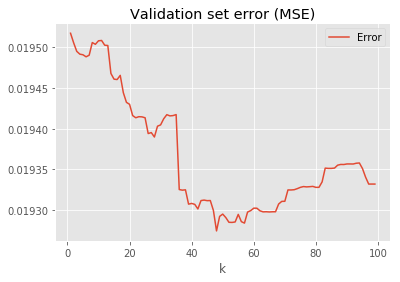

In [14]:
error_svd = pd.DataFrame(err_svd)
error_svd.plot(x='k', y='Error', title='Validation set error (MSE)')

As evident from the graph above, the error decreases till around k= 50 and then start to increase again. We hence select k = 50 as the optimal value of k.

We used the full training(train + validation) set to train the final benchmark model.

In [15]:
opimal_k = 50
u, s, vt = svds(X_full_tr, k = opimal_k)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('Train error (MSE): ', error(X_full_tr, X_pred),'\nTest Error (MSE): ',  error(X_te, X_pred))

Train error (MSE):  0.021480888204272245 
Test Error (MSE):  0.009597420895097143


Benchmark model performed as above and we hope to do better than this with our matrix factorization implementaion.

### Matrix Factorization Implementation

We implemented a matrix factorization based model and used alternating least squares as the optimizing algorithm.

Here we factorize the rating matrix(X) as a product of two matrices(U and V) to capture the general trend in X:

X = U @ $V^{T}$

In [16]:
def train(X, X_te, k, U, V, niters=51, lam=10, verbose=False):
    """ Train a collaborative filtering model. 
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            X_te (numpy 2D array) : the testing ratings matrix as specified above
            k (int) : the number of features use in the CF model
            U (numpy 2D array) : an initial matrix of features for each user
            V (numpy 2D array) : an initial matrix of features for each book
            niters (int) : number of iterations to run
            lam (float) : regularization parameter
            verbose (boolean) : verbosity flag for printing useful messages
            
        Returns:
            (U,V) : A pair of the resulting learned matrix factorization
    """
    W = np.zeros(X.shape)
    mask = X!=0
    mask2 = mask.T
    xtrans = X.T
    
    for i in range(niters):
        for m in range(U.shape[0]):
            v = V[mask[m]]
            r = X[m][mask[m]]
            um = np.linalg.solve(v.T @ v + lam*np.identity(v.shape[1]), v.T @ r)
            U[m] = um

        for n in range(V.shape[0]):
            u = U[mask2[n]]
            r2 = xtrans[n][mask2[n]]
            vn = np.linalg.solve(u.T @ u + lam*np.identity(u.shape[1]), u.T @ r2)
            V[n] = vn
        if(verbose and i%5==0):
            X_pred = (U@V.T)
            print(i,error(X, X_pred),error(X_te, X_pred))
    return U,V

#### Hyper-parameter Tuning

Once again, we tune the hyper-parameter(k) based on the minimum validation set error. 

In [ ]:
err_mf = []
for k in range(10,300, 10):
    U0 = np.random.random((len(user_ID),k))
    V0 = np.random.random((len(book_ID),k))
    U1,V1 = train(X_tr, X_te, k, U0, V0, niters=10, lam=10, verbose=False)
    X_pred = (U1@V1.T)
    err_mf.append({'k': k, 'Error': error(X_val, X_pred)})

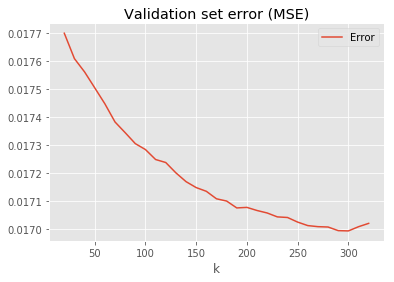

In [17]:
error_mf = pd.DataFrame(err_mf)
error_mf[].plot(x='k', y='Error', title='Validation set error (MSE)')

As seen in the graph, the validation set error reduces at first and then starts to increase again after 300. We consider k = 300 as the optimal value based on the validation set error and we will train the final model using this value of k.

### Training our final model

In [19]:
opimal_k = 300

U0 = np.random.random((len(user_ID),opimal_k))
V0 = np.random.random((len(book_ID),opimal_k))
U1,V1 = train(X_full_tr, X_te, opimal_k, U0, V0, niters=100, lam=10, verbose=False)
X_pred = (U1@V1.T)
print('Training error (MSE): ',error(X_full_tr, X_pred), '\nTest error (MSE): ', error(X_te, X_pred))

Training error (MSE):  0.0004985704743719829 
Test error (MSE):  0.008496272464025829


### Result

Based on the test set error (MSE), our model works slightly better than the benchmark model w.r.t values of k used.

- Performance for benchmark:
    - Train error (MSE):  0.021480888204272245 
    - Test Error (MSE):  0.009597420895097143


- Performance for our implementation:
    - Training error (MSE):  0.0004985704743719829 
    - Test error (MSE):  0.008496272464025829

Our implementaion of matrix factorization performs around 10% better than the benchmark model.

NOTE: This observation is based on the test set error when benchmark was trained with k = 50 and our implementaion was trained with k = 300. Value of k used for each model was the optimized value for that model.

## Providing Recommendations

Let's generate recommendations for all the users in the database. Using the trained model, we can predict the rating that a user will give to each book in the database. Based on these predicted ratings, we can recommend a book that we predict that the user will rate highly.

In [20]:
def recommend(X, U, V, bIds):
    """ Recommend a new book for every user.
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            U (numpy 2D array) : a learned matrix of features for each user
            V (numpy 2D array) : a learned matrix of features for each book
            bIds : a list of book ids corresponding to the columns of the ratings matrix
        Returns
            (list) : a list of book ids recommended for each user
    """
    mask = X!=0
    X_hat = (U@V.T)
    X_hat[mask] = -1
    rec_list = np.argmax(X_hat,axis=1)
    mov = [bIds[i] for i in rec_list]
    return mov
        
recommendations = recommend(X_tr, U1, V1, bIds)
print('ISBN-10 of the books recommeded for first 5 users: ',recommendations[:5])

ISBN-10 of the books recommeded for first 5 users:  ['544337999', '765368544', '143119680', '544337999', '8259844']


### Presenting Recommendations

Book ids are not an ideal way to recommend a book (at least not to a human), we need to present the recommendation with more relevant information in order to have the user interested in reading the book.

In [22]:
import urllib

def present_recommendation(recommended_id, book_data):
    book_info = book_data.loc[recommended_id]
    image_url = book_info['image_url']
    
    f = urllib.request.urlopen(image_url)
    print('Book Name:', book_info['name'])
    print('By-', book_info['author'])
    a = plt.imread(f, 0)
    plt.imshow(a)
    plt.grid(False)
    plt.axis('off')

    plt.show()

#### An example of a recommendation

Book Name: Unfinished Tales of Númenor and Middle-earth
By- J.R.R. Tolkien


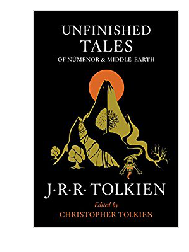

In [23]:
present_recommendation(recommendations[3], books.set_index(['ISBN.10']))

### Aside : Item - Item based approach

Experimenting with the item-item based approach as discussed in class, we were surprised to find that it provided a much better prediction of book-user ratings in our case.

At one point of time, Amazon used an item-item based approach but the recommendations are generic and not personalized to a user. It seemed to work well our case because of the limited data we had. We believe that the matrx factorization will work better if we have different types of books and information of users who don't only read bestselling books. This bias towards recommending highly rated book to everyone is reduced by using matrix factorization.

Here is our implementation of item-item based collaborative filtering.

In [32]:
X = X_full_tr.T
book_means = np.array([X[i,X[i,:]!=0].mean() for i in range(X.shape[0])])
        
def all_pearson(X, book_means, min_common_items=2):
    X_norm = (X - book_means[:,None])*(X != 0)
    X_col_norm = (X_norm**2) @ (X_norm != 0).T
    common_items = (X!=0).astype(float) @ (X!=0).T
    return (X_norm @ X_norm.T)/(np.sqrt(X_col_norm*X_col_norm.T)+1e-12) * (common_items >= min_common_items)
W_pearson = all_pearson(X, book_means)    

def nearest_neighbors(W, K):
    W_neighbors = W.copy()
    W_neighbors[W < np.percentile(np.abs(W), 100-100*K/X.shape[0], axis=0)] = 0
    return W_neighbors
W_pearson_100 = nearest_neighbors(W_pearson, 100)

def predict_user_user(X, W, book_means, i):
    """ Return prediction of X_(ij). """
    return book_means[i] + (np.sum((X - book_means[:,None]) * (X != 0) * W[i,:,None], axis=0) / 
                            (np.sum((X != 0) * np.abs(W[i,:,None]), axis=0) + 1e-12))
rows = [predict_user_user(X, W_pearson, book_means, i) for i in range(X.shape[0])]

final = np.stack(rows, axis =1)
final.shape

(181240, 236)

In [34]:
print('Error on test set (MSE): ', error(X_te, final))

Error on test set (MSE):  0.0005188175269483318


## Next Steps

1. To improve the recommender model, we suggest the inclusion of genre and synopsis of the book. Topic modelling can be used to cluster these books into different sets. Along with these clusters, genre, author(s) can be used to predict what books would a user like.

2. Inclusion of user data like age, gender, location etc, will allow more specific recommendations as similar users can be more accurately matched.

3. Adding more books to the dataset would ensure that low ratings for books are also included. This will help recommend better books.

## Scripts and Data

- Scraping script : https://github.com/arpitchaudhary/book_recommendation/tree/master/Scraping%20scripts
- Dataset: https://github.com/arpitchaudhary/book_recommendation/tree/master/dataset

### References for Further Investigation

- https://pm429015.wordpress.com/2013/05/21/singular-value-decomposition-svd/
- https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea
- https://www.cs.cmu.edu/~venkatg/teaching/CStheory-infoage/book-chapter-4.pdf
- https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
- http://www.datasciencecourse.org/notes/recommender/
- https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75
- http://acsweb.ucsd.edu/~dklim/mf_presentation.pdf
- Assignment 4, Practical Data Science (Spring 2018) 15-688